In [1]:
import numpy as np
import trackpy as tp
import random
import pandas as pd
import skimage.measure
import matplotlib.pyplot as plt
import glob
import tifffile
from organoid_tracking import organoid_tracking

In [2]:
def test_make_organoid_masks(x,y,r,L):

    X,Y = np.ogrid[:L, :L]

    assert isinstance(x, list)
    assert isinstance(y, list)
    assert len(x) == len(y)

    test_image = np.zeros((L, L))

    for xn, yn, n in zip(x,y,range(len(x))):

        distance = np.sqrt((X-xn)**2 + (Y-yn)**2)
        test_image[distance<r] = n

    return test_image.astype(int)

def test_image():

    # number of organoids
    n = random.sample([1,2,3,4], 1)[0]
    L = 30

    # organoid positions
    r = 5
    x = random.sample(range(0, L), n)
    y = random.sample(range(0, L), n)
    
    test_image = test_make_organoid_masks(x,y,r,L)

    return test_image.astype(int)

def test_image_sequence():
    
    n = random.sample([10,11,12,13], 1)[0]
    
    return np.array([test_image() for  i in range(n)])

In [3]:
image = test_image()

check that the test images are correct:

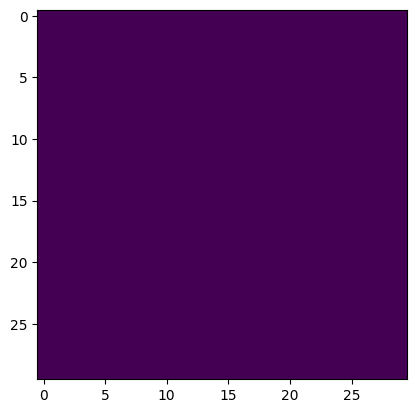

In [4]:
plt.imshow(image)

we verify that the information we get is relevant:

In [5]:
organoid_tracking.get_mask_properties(image)

,y,x,perimeter,area


## analyzing an image sequence

we get the organoid properties sequentially and then link the individual organoids together using trackpy.

In [20]:
def single_movie_trajs(image_sequence,
                       max_step = 50):

    """ From images sequences to trajectories """

    organoid_data = pd.DataFrame()

    for image, frame in zip(image_sequence, range(len(image_sequence))):
        
        properties = organoid_tracking.get_mask_properties(image)
        properties['frame'] = frame
        
        organoid_data = pd.concat([organoid_data, properties], 
                                ignore_index=True)

    organoid_data = tp.link(organoid_data, max_step, memory=3)

    return organoid_data

In [6]:
test_image_sequence = test_image_sequence()

In [7]:
path_to_imgs = '/Users/gustaveronteix/Documents/Code/Orakl/collective_ameobide/CNV029-Masks&DIC/Coll_CT-Stacks-masks'
fnames = glob.glob(os.path.join(path_to_imgs, '*.tiff'))

In [18]:
os.path.basename(fnames[0])

'CNV029_040-masks.tiff'

In [21]:
file_data = pd.DataFrame()

for movie_name in fnames:

    filename = os.path.basename(movie_name)
    filename, _ = filename.split('.')

    image_sequence = tifffile.imread(movie_name)

    # if spurious channels remove extra RGB one
    if image_sequence.ndim == 4:
        single_channel_image_sequence = image_sequence[..., 0]
        image_sequence = single_channel_image_sequence
        del(single_channel_image_sequence)

    # check that dimensions are OK
    assert image_sequence.ndim == 3

    movie_frame = single_movie_trajs(image_sequence,
                       max_step = 50)
    movie_frame['movie_name'] = filename

    file_data = pd.concat([file_data, movie_frame], 
                                ignore_index=True)



Frame 41: 3 trajectories present.


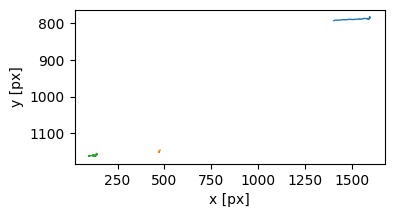

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [22]:
plt.figure(figsize=(4,2))
tp.plot_traj(movie_frame)